<a href="https://colab.research.google.com/github/kb107/MNIST-Handwritten-Digit-Recogniser/blob/main/MNISTfromscratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Handwritten Digit Recogniser**
#### MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.
#### A small introduction to the dataset for people who are unfamiliar: The MNIST dataset consists of 70000 images of handwritten digits from 0-9, with each image being of dimension 28 x 28 pixels.
#### The primary goal is to create a Machine Learning model which is able to provide a satisfactory prediction accuracy on the dataset. For this purpose, a Neural Network was the best choice due to its proficiency at learning non-linear relationships in data. 
#### The entire Neural Network model has been built from scratch using the Python numpy library. 
### **Brief Description of the Neural Network:**
#### The NN that is being designed has 4 distinct layers out of which 2 are hidden layers. The first layer has 784 nodes each containing a pixel value of the image. The 2nd layer has 128 nodes, the 3rd node has 64 nodes and the last layer(the output layer) has 10 nodes, each providing the probability of the input image belonging to a particular digit class.

In [84]:
import numpy as np 
import sklearn 
import keras
import pickle
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

### Importing the Dataset

In [37]:
from sklearn.datasets import fetch_openml
from keras.utils.np_utils import to_categorical

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = to_categorical(y)
X = (X/255).astype(np.float32)

### Splitting the Dataset into a training set and test set

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Setting the number of nodes in each layer

In [39]:
size = [784, 128, 64, 10]

### Initialising the parameters of the NN

In [40]:
from numpy.random import randn

params = { 'w1' : randn(size[1], size[0]) / np.sqrt(size[0]),
           'b1' : randn(size[1], 1) / np.sqrt(size[0]),
           'w2' : randn(size[2], size[1]) / np.sqrt(size[1]),
           'b2' : randn(size[2], 1) / np.sqrt(size[1]),
           'w3' : randn(size[3], size[2]) / np.sqrt(size[2]),
           'b3' : randn(size[3], 1) / np.sqrt(size[2])}
cache = {}
gradient = {}
alpha = 0.001
epochs = 10

In [41]:
def sigmoid(z, derivative=False):
    sig = 1 / (1 + np.exp(-z))
    if derivative:
        return sig * (1 - sig)
    else: 
        return sig

### Since we desire the output of the NN to be relative probabilities of the image belonging to different digit categories, we define the softmax function to achieve the same. The subtraction of ```z.max()``` in the first step is to prevent overflows associated with large exponentials.

In [307]:
def softmax(z, derivative=False):
    prob = np.exp(z - z.max())
    prob = prob / np.sum(prob)
    if derivative:
        return prob * (1 - prob)
    else:
        return prob

### Function to perform Forward Propagation

In [43]:
def forward_prop(x):
    global params, cache
    cache['a0'] = x
    cache['z1'] = np.dot(params['w1'], cache['a0']) + params['b1']
    cache['a1'] = sigmoid(cache['z1'])
    cache['z2'] = np.dot(params['w2'], cache['a1']) + params['b2']
    cache['a2'] = sigmoid(cache['z2'])
    cache['z3'] = np.dot(params['w3'], cache['a2']) + params['b3']
    cache['o'] = softmax(cache['z3'])

### Function to perform Backward Propagation

In [44]:
def backward_prop(y):
    global params, cache, gradient
    cache['del3'] = (cache['o']-y) * softmax(cache['z3'], derivative=True)
    cache['del2'] = np.dot(params['w3'].T, cache['del3']) * sigmoid(cache['z2'], derivative=True)
    cache['del1'] = np.dot(params['w2'].T, cache['del2']) * sigmoid(cache['z1'], derivative=True)

    gradient['w3'] = np.dot(cache['del3'], cache['a2'].T)
    gradient['b3'] = cache['del3']
    gradient['w2'] = np.dot(cache['del2'], cache['a1'].T)
    gradient['b2'] = cache['del2']
    gradient['w1'] = np.dot(cache['del1'], cache['a0'].T)
    gradient['b1'] = cache['del1']

### Function to perform Stochastic Gradient Descent

In [45]:
def gradient_descent(alpha):
  global params, gradient
  params['w3'] -= alpha * gradient['w3']
  params['w2'] -= alpha * gradient['w2']
  params['w1'] -= alpha * gradient['w1']
  params['b3'] -= alpha * gradient['b3']
  params['b2'] -= alpha * gradient['b2']
  params['b1'] -= alpha * gradient['b1']

### Function to train the NN

In [59]:
def train(X_train, y_train, epochs, alpha):
  n = len(X_train)
  for i in range(epochs):
    for j in range(n):
      if j == 0 or j == 27999 or j == 55999:
        print(i+1, ':', j+1) 
      x = np.array([X_train[j]])
      x = x.reshape(784,1)
      y = np.array([y_train[j]])
      y = y.reshape(10,1)
      forward_prop(x)
      backward_prop(y)
      gradient_descent(alpha)

In [72]:
train(X_train, y_train, epochs=1, alpha=0.01)

1 : 1
1 : 28000
1 : 56000


#### The output shown above is a bit misleading since the NN was not trained for merely 1 epoch. The NN was trained intially for 30 epochs which achieved a prediction accuracy of 94.5% on the training set. Following this it was trained for 8 epochs while also checking the prediction accuracy after each epoch to prevent overfitting. Following the 38 epochs it achieved a prediction accuracy of 94.8857% on the training set which fell to 94.87% after the 39th epoch thus signifying overfitting and hence the training process was stopped. 

### Function to calculate prediction accuracy

In [65]:
def pred_accuracy(X_train, y_train):
  pred_acc = []
  n = len(X_train)
  for j in range(n):
    if j == 0 or j == 5000 or j == 13999:
      print(j+1)
    x = np.array([X_train[j]])
    x = x.reshape(784,1)
    y = np.array([y_train[j]])
    y = y.reshape(10,1)
    forward_prop(x)
    pred = np.argmax(cache['o'])
    pred_acc.append(pred == np.argmax(y))
  return np.mean(pred_acc)


In [155]:
acc = pred_accuracy(X_test, y_test)
print('Accuracy on test set: ', acc)

1
5001
14000
Accuracy on test set:  0.9487857142857142


#### The above cell shows the prediction accuracy after 39 epochs.

### Saving the NN parameters for future predictions

In [79]:
file = open('mnist_model.pkl', 'wb')
pickle.dump(params, file)
file.close()

### Function to predict the digit on an image using the NN parameters

In [303]:
def predict_num(img):
  x = (img.flatten() / 255).astype(np.float32)
  x = np.array([x])
  x = x.T
  forward_prop(x)
  pred = np.argmax(cache['o'])
  print('Model Prediction: ', pred)


### **Some successful predictions:**

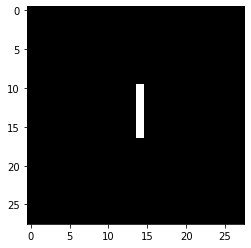

In [309]:
img = cv2.imread('num1.jpg', 0)
img = cv2.resize(img, (28, 28))
ret, img = cv2.threshold(img, thresh=120, maxval=255, type=cv2.THRESH_BINARY_INV)
plt.imshow(img, cmap='gray')

In [310]:
predict_num(img)

Model Prediction:  1


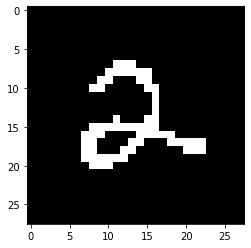

In [311]:
img = cv2.imread('num2.jpg', 0)
img = cv2.resize(img, (28, 28))
ret, img = cv2.threshold(img, thresh=120, maxval=255, type=cv2.THRESH_BINARY_INV)
plt.imshow(img, cmap='gray')

In [312]:
predict_num(img)

Model Prediction:  2


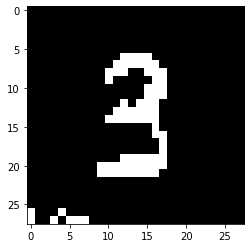

In [314]:
img = cv2.imread('num3.jpg', 0)
img = cv2.resize(img, (28, 28))
ret, img = cv2.threshold(img, thresh=115, maxval=255, type=cv2.THRESH_BINARY_INV)
plt.imshow(img, cmap='gray')

In [315]:
predict_num(img)

Model Prediction:  3


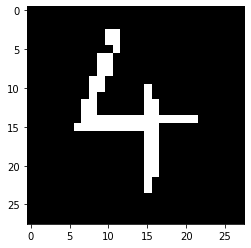

In [316]:
img = cv2.imread('num4.jpg', 0)
img = cv2.resize(img, (28, 28))
ret, img = cv2.threshold(img, thresh=120, maxval=255, type=cv2.THRESH_BINARY_INV)
plt.imshow(img, cmap='gray')

In [317]:
predict_num(img)

Model Prediction:  4


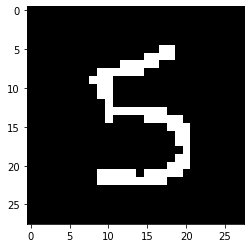

In [318]:
img = cv2.imread('num5.jpg', 0)
img = cv2.resize(img, (28, 28))
ret, img = cv2.threshold(img, thresh=120, maxval=255, type=cv2.THRESH_BINARY_INV)
plt.imshow(img, cmap='gray')

In [319]:
predict_num(img)

Model Prediction:  5


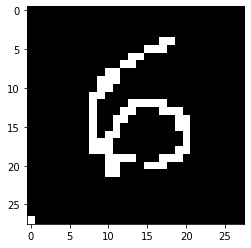

In [325]:
img = cv2.imread('num6.jpg', 0)
img = cv2.resize(img, (28, 28))
ret, img = cv2.threshold(img, thresh=160, maxval=255, type=cv2.THRESH_BINARY_INV)
plt.imshow(img, cmap='gray')

In [326]:
predict_num(img)

Model Prediction:  6


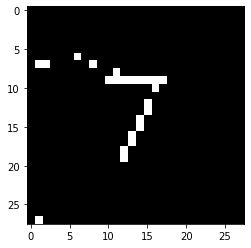

In [332]:
img = cv2.imread('num7.jpg', 0)
img = cv2.resize(img, (28, 28))
ret, img = cv2.threshold(img, thresh=80, maxval=255, type=cv2.THRESH_BINARY_INV)
plt.imshow(img, cmap='gray')

In [333]:
predict_num(img)

Model Prediction:  7


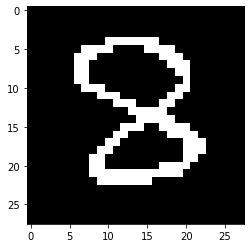

In [334]:
img = cv2.imread('num8.jpg', 0)
img = cv2.resize(img, (28, 28))
ret, img = cv2.threshold(img, thresh=120, maxval=255, type=cv2.THRESH_BINARY_INV)
plt.imshow(img, cmap='gray')

In [335]:
predict_num(img)

Model Prediction:  8


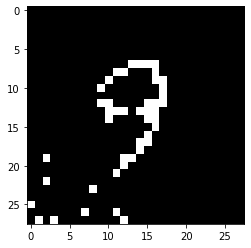

In [339]:
img = cv2.imread('num9.jpg', 0)
img = cv2.resize(img, (28, 28))
ret, img = cv2.threshold(img, thresh=123, maxval=255, type=cv2.THRESH_BINARY_INV)
plt.imshow(img, cmap='gray')

In [340]:
predict_num(img)

Model Prediction:  9


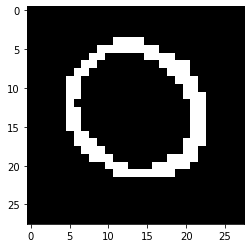

In [361]:
img = cv2.imread('num0.jpg', 0)
img = cv2.resize(img, (28, 28))
ret, img = cv2.threshold(img, thresh=100, maxval=255, type=cv2.THRESH_BINARY_INV)
plt.imshow(img, cmap='gray')

In [362]:
predict_num(img)

Model Prediction:  0


# ***Thank You!***